# XGBoost

In [2]:
!pip install xgboost

  Using cached xgboost-2.1.0-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.0-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl (2.1 MB)


## 特徴量を選択してグリットサーチでモデルをトレーニングする

In [ ]:
#####

Fitting 10 folds for each of 3072 candidates, totalling 30720 fits
Best parameters found: {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 5.620253164556962, 'subsample': 0.6}
Best cross-validation AUC: 0.8311
Cross-Validation AUC Scores: [0.92117275 0.8065309  0.8396158  0.80953244 0.84360275 0.86208771
 0.81232345 0.72846045 0.82344633 0.86423023]
Mean Cross-Validation AUC: 0.8311002813340214
Test AUC: 0.8178963740643531
過学習の可能性があります: Cross-Validation AUCがTest AUCを0.0132039だけ上回っています。


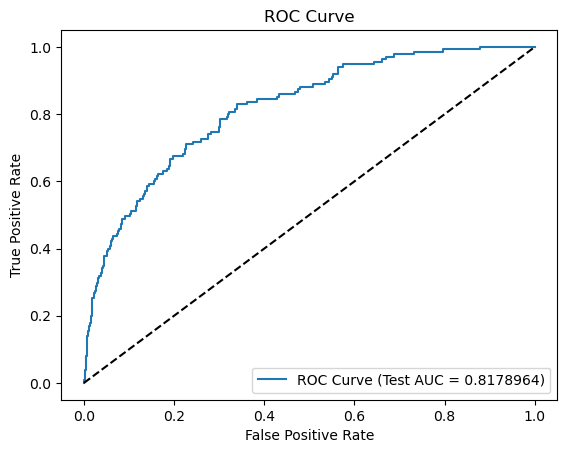

最適なXGBoostモデルが /Users/hayakawakazue/Downloads/signate/model/xgboost_grid_830_12.joblib に保存されました。


In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'Product_Designation_Target_Encoding', 'FamilySize',
    'MaritalStatus', 'Income_Bucket_Rank', 'Passport', 
    'Age_MonthlyIncome_Interaction', 'Occupation_Large_Business', 'Gender_Female',
    'EngagementScore', 'Cluster_ProdTaken_Ratio', 'NumberOfTrips',
    'TypeofContact_Company_Invited', 'Occupation_Salaried', 'Age_ProdTaken_Mean',
    'ProductPitched_Satisfaction', 'Satisfaction_PerVisitor', 'ProductPitched_Rank',
    'CityTier_Age_Income_x_FamilySize_Income', 'PreferredPropertyStar'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]  # 特徴量を選択
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

# クラスの比率からscale_pos_weightを計算
neg, pos = np.bincount(y_train)
scale_pos_weight = neg/pos

# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'gamma': [ 0.1, 0.2, 0.3, 0.5],
    'scale_pos_weight': [scale_pos_weight]
}

# XGBoostモデルの定義
xgb_model = XGBClassifier(eval_metric='logloss', random_state=21)

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

# グリッドサーチの設定
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=skf, scoring='roc_auc', 
                               n_jobs=-1, verbose=1)

# グリッドサーチの実行
xgb_grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {xgb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {xgb_grid_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = xgb_grid_search.best_estimator_

# 最適なモデルを全データで再トレーニング
xgb_best.fit(X_train, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'xgboost_grid_830_12.joblib')
joblib.dump(xgb_best, model_path)
print(f"最適なXGBoostモデルが {model_path} に保存されました。")


## モデルが重視する特徴量を可視化する

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation AUC: 0.8143
Test AUC: 0.8239233984640809
Model's most important features (Top 20):
                                    Feature  Importance
21                         Designation_Rank    0.207663
36                 Designation_PropertyStar    0.115505
22                       Income_Bucket_Rank    0.101227
13            Age_MonthlyIncome_Interaction    0.051542
7                                  Passport    0.035773
20                      ProductPitched_Rank    0.033438
15                   CityTier_MonthlyIncome    0.033266
9                             MonthlyIncome    0.026393
27               TypeofContact_Self_Enquiry    0.026137
31                            Gender_Female    0.024280
34                          EngagementScore    0.023587
6                    

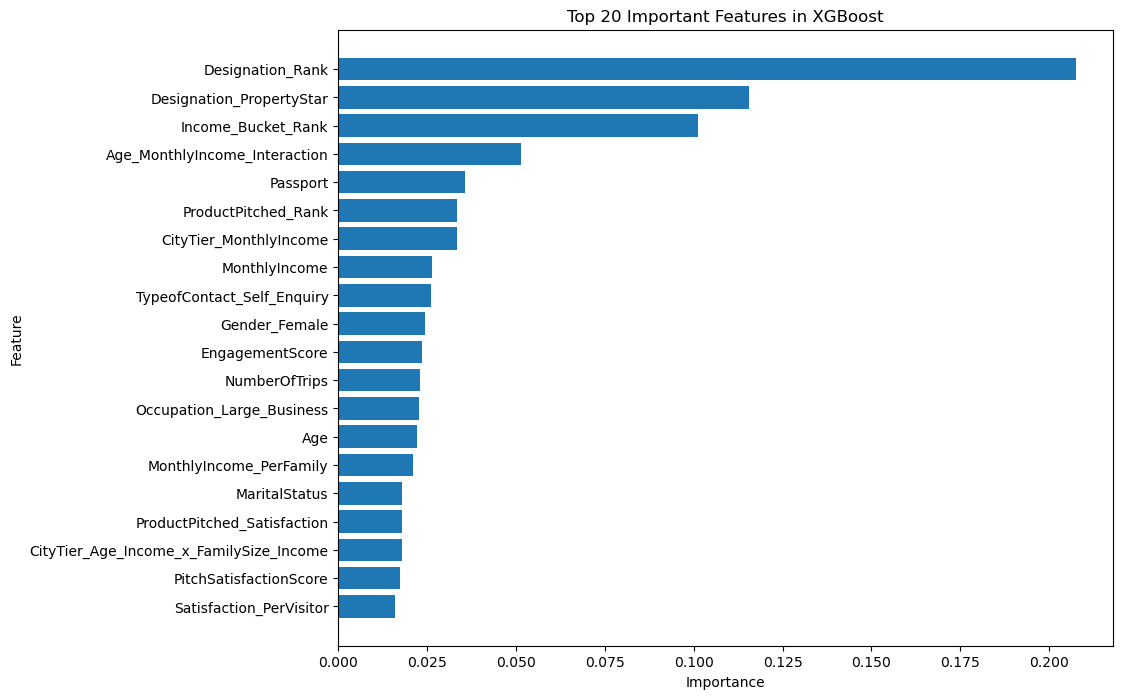

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31, stratify=y)

# XGBoostモデルの定義
xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=31)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# StratifiedKFoldを設定
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=31)

# ランダムサーチの設定
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                       n_iter=10, cv=kfold, scoring='roc_auc', n_jobs=-1, 
                                       verbose=1, random_state=31)

# トレーニングデータでランダムサーチを実行
xgb_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {xgb_random_search.best_params_}")
print(f"Best cross-validation AUC: {xgb_random_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = xgb_random_search.best_estimator_

# テストデータでの予測とAUC計算
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 重要度の取得と上位20の特徴量を可視化
importance = xgb_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# 重要な特徴量のリストを表示
print("Model's most important features (Top 20):")
print(importance_df)

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features in XGBoost')
plt.gca().invert_yaxis()  # 最も重要な特徴量を上に表示
plt.show()


## 特徴量を選択しランダムサーチでトレーニングする

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
Best parameters found: {'subsample': 0.3, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.005, 'gamma': 0.6, 'colsample_bytree': 0.3}
Best cross-validation AUC: 0.8181
Cross-Validation AUC Scores: [0.78089888 0.85463483 0.72963483 0.76404494 0.82303371 0.84550562
 0.7886236  0.8125     0.83707865 0.87359551 0.80196629 0.87359551
 0.88539326 0.8        0.75730337 0.85543071 0.72798295 0.81960227
 0.94744318 0.78338068]
Mean Cross-Validation AUC: 0.8180824395641813
Test AUC: 0.8268008165645961
過学習の兆候は見られません。


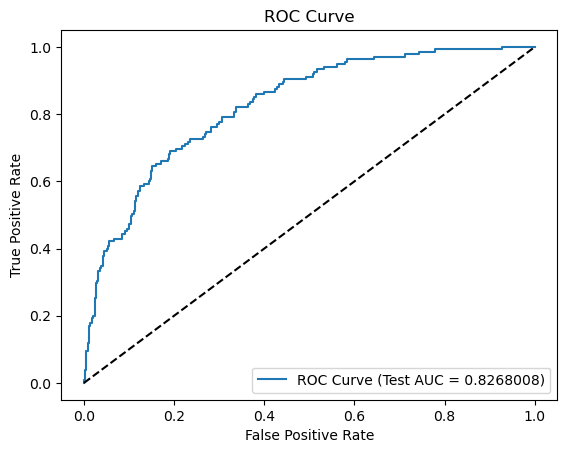

最適なXGBoostモデルが /Users/hayakawakazue/Downloads/signate/model/xgboost_random_0901_11.joblib に保存されました。


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Designation_Rank', 'Designation_PropertyStar',
    'Income_Bucket_Rank', 'Age_MonthlyIncome_Interaction', 'Passport', 
    'ProductPitched_Rank', 'CityTier_MonthlyIncome', 'MonthlyIncome',
    'TypeofContact_Self_Enquiry', 'Gender_Female', 'EngagementScore',
    'NumberOfTrips', 'Occupation_Large_Business', 'Age',
    'MonthlyIncome_PerFamily', 'MaritalStatus', 'ProductPitched_Satisfaction',
    'CityTier_Age_Income_x_FamilySize_Income', 'PitchSatisfactionScore',
    'Satisfaction_PerVisitor'
    
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18, stratify=y)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3],
    'learning_rate': [0.001, 0.005],
    'subsample': [0.2, 0.3],
    'colsample_bytree': [0.2, 0.3],
    'gamma': [0.4, 0.5, 0.6]
}

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=18)

# XGBoostモデルの定義
xgb_model = XGBClassifier(eval_metric='logloss', random_state=18)

# ランダムサーチの設定
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                       n_iter=50, cv=skf, scoring='roc_auc', n_jobs=-1, random_state=18, 
                                       verbose=1)

# ランダムサーチの実行
xgb_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {xgb_random_search.best_params_}")
print(f"Best cross-validation AUC: {xgb_random_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = xgb_random_search.best_estimator_

# 最適なモデルを全データで再トレーニング
xgb_best.fit(X_train, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'xgboost_random_0901_11.joblib')
joblib.dump(xgb_best, model_path)
print(f"最適なXGBoostモデルが {model_path} に保存されました。")


## RFEを設定しグリットサーチでモデルをトレーニングする

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters found: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.4}
Best cross-validation AUC: 0.8274
Selected features: Index(['NumberOfPersonVisiting', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'MaritalStatus',
       'Age_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction',
       'CityTier_Age', 'Income_Per_Age', 'Satisfaction_PerVisitor',
       'AverageIncome', 'ProductPitched_Rank', 'Designation_Rank',
       'Income_Bucket_Rank', 'Age_Income_Interaction_Rank',
       'DurationOfPitch_Category_Rank', 'Age_ProdTaken_Bucket_Rank',
       'AgeGroup_Rank', 'TypeofContact_Company Invited',
       'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Gender_Female', 'Gender_Male'],
      dtype='object')
Cross-Validation AUC Scores: [0.80925637 0.80477888 0.81971388 0.81718232 0.8274419

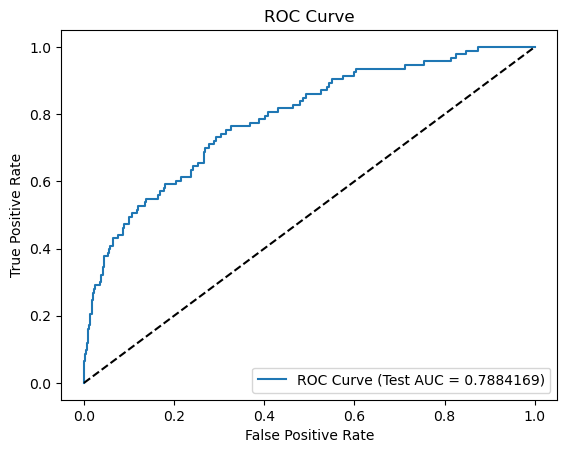

最適なXGBoostモデルが /Users/hayakawakazue/Downloads/signate/model/xgboost_0820_3.joblib に保存されました。


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0820.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2],
    'learning_rate': [0.01],
    'subsample': [0.4, 0.5],
    'colsample_bytree': [0.5],
    'gamma': [0, 0.3, 0.4]
}

# XGBoostモデルの定義（分類用）
xgb_model = XGBClassifier(eval_metric='logloss', random_state=23)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)  # n_splitsを10に設定

# グリッドサーチの設定
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
xgb_grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {xgb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {xgb_grid_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = xgb_grid_search.best_estimator_

# RFEを使用して特徴量選択を実行
selector = RFE(xgb_best, n_features_to_select=25)  # ここで選択する特徴量の数を指定
selector = selector.fit(X_train, y_train)

# 選択された特徴量の確認
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# 選択された特徴量で再度モデルをトレーニング
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
xgb_best.fit(X_train_selected, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = xgb_grid_search.cv_results_['mean_test_score']
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {np.mean(cv_scores)}")

# テストデータでの予測とAUC計算
y_pred_proba = xgb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'xgboost_0820_3.joblib')
joblib.dump(xgb_best, model_path)
print(f"最適なXGBoostモデルが {model_path} に保存されました。")


## RFEを設置してランダムサーチでモデルをトレーニングする

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.25, 'n_estimators': 30, 'max_depth': 2, 'learning_rate': 0.0005, 'gamma': 0.3, 'colsample_bytree': 0.4}
Best cross-validation AUC: 0.7913
Selected features: Index(['Passport', 'MonthlyIncome', 'Designation_ProdTaken_Mean',
       'Age_ProdTaken_Mean', 'FamilySize', 'CityTier_Age', 'averageIncome',
       'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry',
       'Occupation_Salaried', 'ProductPitched_Basic', 'Designation_Executive',
       'Income_Binned_Very Low', 'Age_ProdTaken_Bucket_Very High',
       'AgeGroup_25-29', 'AgeGroup_50-54', 'AgeGroup_55-59', 'AgeGroup_60-64',
       'ProductPitchedScore', 'StatusScore'],
      dtype='object')
Cross-Validation AUC Scores: [0.84328767 0.80136986 0.78027397 0.78013699 0.76328767 0.68520548
 0.85712329 0.74383562 0.81934932 0.81549658]
Mean Cross-Validation AUC: 0.7889366438356163
Test AUC: 0.8200289375775114
過学習の兆候は見られません。


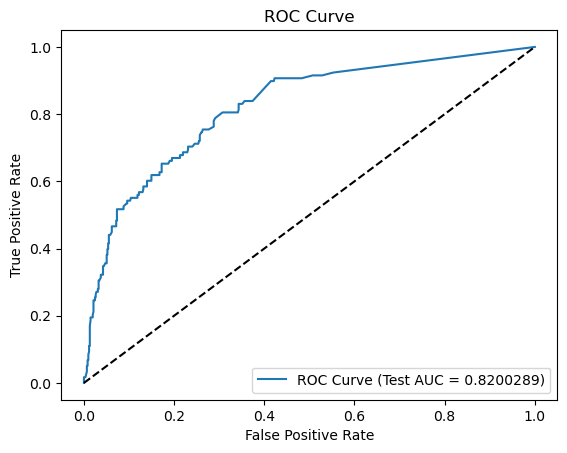

最適なXGBoostモデルが /Users/hayakawakazue/Downloads/signate/model/xgboost_best0814_3.joblib に保存されました。


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

# ハイパーパラメータの候補を設定
param_dist = {
    'n_estimators': [10, 30],
    'max_depth': [2, 3],
    'learning_rate': [0.0005, 0.001],
    'gamma': [0.2, 0.3, 0.5],
    'subsample': [0.2, 0.25],
    'colsample_bytree': [0.4, 0.5]
}

# XGBoostモデルを定義
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=18)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=18)  # n_splitsを10に設定

# ランダムサーチの設定
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=skf, 
                                   scoring='roc_auc', n_jobs=-1, verbose=1, random_state=18)

# ランダムサーチの実行
random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation AUC: {random_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = random_search.best_estimator_

# RFEを使用して特徴量選択を実行
selector = RFE(xgb_best, n_features_to_select=25)  # ここで選択する特徴量の数を指定
selector = selector.fit(X_train, y_train)

# 選択された特徴量の確認
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# 選択された特徴量で再度モデルをトレーニング
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
xgb_best.fit(X_train_selected, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(xgb_best, X_train_selected, y_train, cv=10, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = xgb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'xgboost_best0814_3.joblib')
joblib.dump(xgb_best, model_path)
print(f"最適なXGBoostモデルが {model_path} に保存されました。")
